In [ ]:
!nvidia-smi

# Libraries

In [6]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, mixed_precision


In [7]:
# import tensorflow as tf
print(tf.__version__)
# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent TensorFlow from allocating all memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error: {e}")
else:
    print("GPU is not available, running on CPU.")

tf.test.is_gpu_available()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision enabled:", policy)

2.18.0
GPU is available and will be used.
Mixed precision enabled: <DTypePolicy "mixed_float16">


I0000 00:00:1753772014.664680      36 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753772014.665406      36 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Imports

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 3
FROZEN_EPOCHS = 2

train_csv_path = "/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip"
train_images_dir = "/kaggle/input/diabetic-retinopathy-train-unzipped/train/"
test_images_dir = "/kaggle/input/diabetic-retinopathy-test-unzipped/test/"
submission_csv_path = "/kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip"

In [9]:
img_number = 10016

df = pd.read_csv(train_csv_path)
df_train = df[:img_number].copy()
df_train.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


**Train Test Split**

In [10]:
# Convert multiclass level to binary: 0 = No DR, 1 = DR Present
df_train["Label"] = df_train["level"].apply(lambda x: False if x == 0 else True)

df_train["filepath"] = df_train["image"].apply(lambda x: os.path.join(train_images_dir, f"{x}.jpeg"))

train_df, val_df = train_test_split(df_train, test_size=0.4, stratify=df_train["Label"], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df["Label"], random_state=42)


In [11]:
print(train_df.shape, val_df.shape, test_df.shape)
# train_df.filepath[0]
train_df

(6009, 4) (2003, 4) (2004, 4)


,image,level,Label,filepath
5408,6808_left,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
5319,6691_right,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
401,457_right,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
7344,9226_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
7246,9100_left,1,True,/kaggle/input/diabetic-retinopathy-train-unzip...
...,...,...,...,...
2538,3149_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
536,650_left,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...
6960,8749_left,3,True,/kaggle/input/diabetic-retinopathy-train-unzip...
3379,4212_right,0,False,/kaggle/input/diabetic-retinopathy-train-unzip...


# Visualization

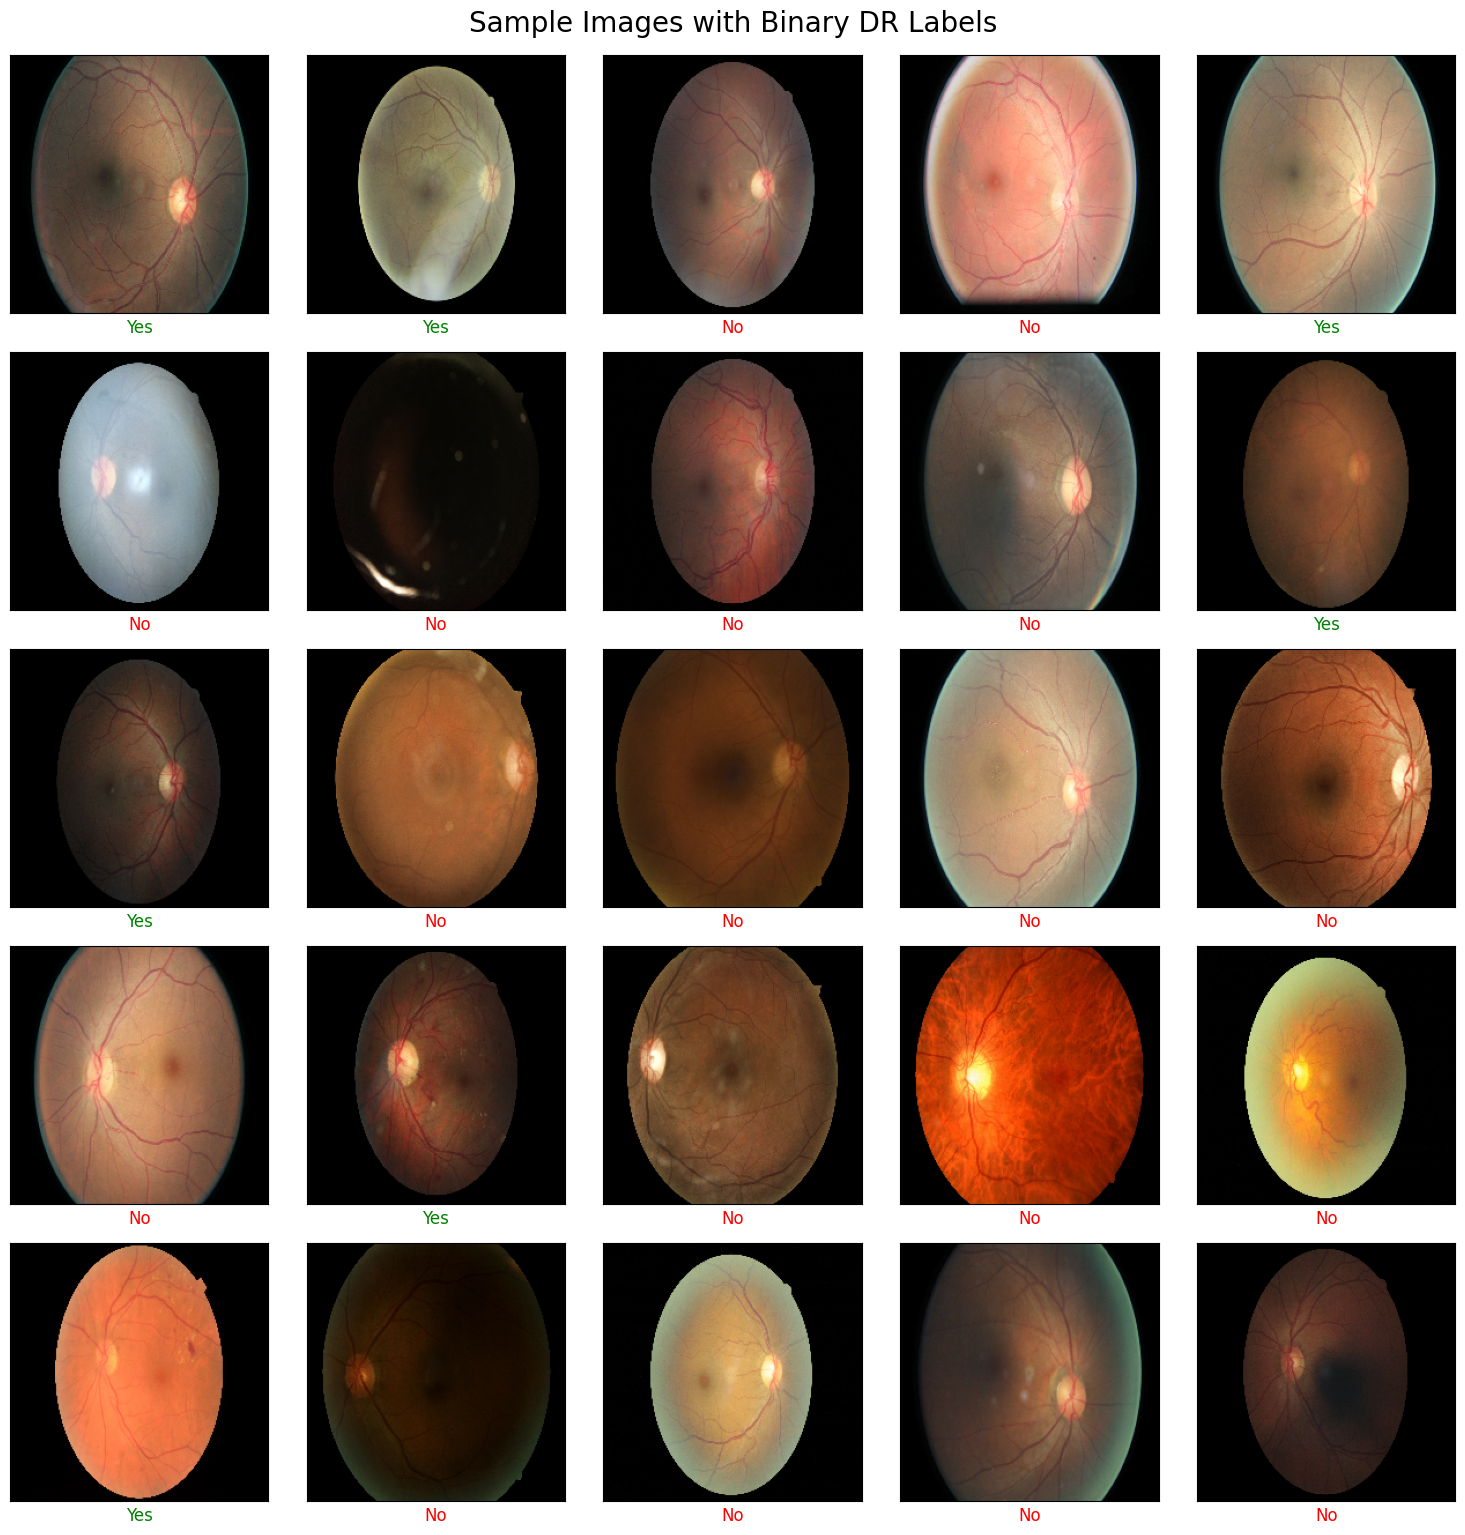

In [12]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# Show first 25 images from train_df
for idx, (i, row) in enumerate(train_df.head(25).iterrows()):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Load and preprocess image
    img_path = row['filepath']
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: Image not found at {img_path}")
        continue
    
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Set label from binary column
    label = row.get('binary_label', row.get('Label', None))
    label_text = 'Yes' if label else 'No'
    
    plt.imshow(img)
    plt.xlabel(label_text, fontsize=12, color='green' if label else 'red')

plt.tight_layout()
plt.suptitle("Sample Images with Binary DR Labels", fontsize=20, y=1.02)
plt.show()


# Evaluation Functions

## Results

In [68]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve
)
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def Results(model, model_name,test_set, save_csv=False):
    # Evaluate the model
    results = model.evaluate(test_set)
    print("Evaluation results: ", results)

    y_true = []
    y_pred_probs = []

    print("Loading....", flush=True)

    for images, labels in test_set:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0).flatten())

    y_true = tf.convert_to_tensor(y_true)
    y_pred_probs = tf.convert_to_tensor(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).numpy().astype("int32")

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    prc_auc = average_precision_score(y_true, y_pred_probs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    npv = tn / (tn + fn)

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PRC AUC: {prc_auc}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Kappa Coefficient: {kappa}")
    print(f"NPV: {npv}")

    if save_csv:
        # Compute ROC and Precision-Recall curves
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        prec, rec, _ = precision_recall_curve(y_true, y_pred_probs)

        # Prepare DataFrame
        max_len = max(len(fpr), len(prec))
        fpr = np.pad(fpr, (0, max_len - len(fpr)), 'constant', constant_values=np.nan)
        tpr = np.pad(tpr, (0, max_len - len(tpr)), 'constant', constant_values=np.nan)
        prec = np.pad(prec, (0, max_len - len(prec)), 'constant', constant_values=np.nan)
        rec = np.pad(rec, (0, max_len - len(rec)), 'constant', constant_values=np.nan)

        df = pd.DataFrame({
            'FPR': fpr,
            'TPR': tpr,
            'Precision': prec,
            'Recall': rec
        })


        file_name = model_name
        df.to_csv(file_name, index=False)
        print(f"Saved metrics to: {file_name}")


In [70]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve
)
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import wandb
import matplotlib.pyplot as plt

def Results(model, test_set, model_name="Model", save_csv=False, wandb_log=False):
    # Evaluate the model
    results = model.evaluate(test_set)
    print("Evaluation results: ", results)

    y_true = []
    y_pred_probs = []

    print("Loading....", flush=True)

    for images, labels in test_set:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0).flatten())

    y_true = tf.convert_to_tensor(y_true)
    y_pred_probs = tf.convert_to_tensor(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).numpy().astype("int32")

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    prc_auc = average_precision_score(y_true, y_pred_probs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    npv = tn / (tn + fn)

    # Print metrics
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PRC AUC: {prc_auc}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Kappa Coefficient: {kappa}")
    print(f"NPV: {npv}")

    # Log metrics to W&B
    if wandb_log:
        wandb.log({
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc,
            "PRC AUC": prc_auc,
            "Kappa": kappa,
            "NPV": npv
        })

    if save_csv or wandb_log:
        # Compute ROC and Precision-Recall curves
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        prec, rec, _ = precision_recall_curve(y_true, y_pred_probs)

        # Pad arrays to same length
        max_len = max(len(fpr), len(prec))
        fpr = np.pad(fpr, (0, max_len - len(fpr)), 'constant', constant_values=np.nan)
        tpr = np.pad(tpr, (0, max_len - len(tpr)), 'constant', constant_values=np.nan)
        prec = np.pad(prec, (0, max_len - len(prec)), 'constant', constant_values=np.nan)
        rec = np.pad(rec, (0, max_len - len(rec)), 'constant', constant_values=np.nan)

        df = pd.DataFrame({
            'FPR': fpr,
            'TPR': tpr,
            'Precision': prec,
            'Recall': rec
        })

        file_name = model_name+'.csv'
        df.to_csv(file_name, index=False)
        print(f"Saved metrics to: {file_name}")

        if wandb_log:
            wandb.save(file_name)

            # Plot ROC Curve
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            wandb.log({"ROC Curve": wandb.Image(plt)})
            plt.close()

            # Plot PR Curve
            plt.figure()
            plt.plot(rec, prec, label=f'PRC AUC = {prc_auc:.2f}')
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            wandb.log({"PR Curve": wandb.Image(plt)})
            plt.close()


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score
import tensorflow as tf

def Results_old(model, test_set):
    # Evaluate the model
    results = model.evaluate(test_set)
    print("Evaluation results: ", results)

    y_true = []
    y_pred_probs = []

    print("Loading....", flush=True)

    for images, labels in test_set:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images, verbose=0).flatten())

    y_true = tf.convert_to_tensor(y_true)
    y_pred_probs = tf.convert_to_tensor(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).numpy().astype("int32")

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    prc_auc = average_precision_score(y_true, y_pred_probs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    npv = tn / (tn + fn)

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PRC AUC: {prc_auc}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Kappa Coefficient: {kappa}")
    print(f"NPV: {npv}")

## MACS & FLOPS

In [15]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, input_shape):
    # Convert Keras model to ConcreteFunction
    concrete_func = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))
    
    # Convert ConcreteFunction to a frozen graph
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Create a session to run the frozen graph
    with tf.compat.v1.Session(graph=tf.Graph()) as sess:
        tf.import_graph_def(graph_def, name="")
        graph = tf.compat.v1.get_default_graph()
        
        # Calculate FLOPs using TensorFlow profiler
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        
    return flops.total_float_ops

In [16]:
# # Define input shape
# input_shape = (1, 224, 224,3 )
# # Calculate FLOPs
# flops = get_flops(model, input_shape)
# macs = flops // 2  # MACs is half the FLOPs for Conv2D

# print(f"MACs: {macs}")
# print(f"FLOPs: {flops}")

## Parameters

In [17]:
import numpy as np

def model_parametersInfo(model):
    """
    Prints total, trainable, and non-trainable parameters of a Keras model.
    """
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])

    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")


## Inference Report

In [18]:
import tensorflow as tf
import psutil
import os
import time

def inference_Report(model, test_set):
    process = psutil.Process(os.getpid())

    if tf.config.list_physical_devices('GPU'):
        gpu_enabled = True
        gpu_device = 'GPU:0'
    else:
        gpu_enabled = False

    print("🔍 Capturing memory stats and inference time for 100 images...\n")

    # --- Before Inference ---
    ram_before = process.memory_info().rss
    gpu_before = tf.config.experimental.get_memory_info(gpu_device)['current'] if gpu_enabled else 0

    total_images = 0
    start_time = time.time()

    for images, _ in test_set:
        for i in range(images.shape[0]):
            if total_images >= 100:
                break
            image = tf.expand_dims(images[i], axis=0)
            _ = model(image, training=False)
            total_images += 1
        if total_images >= 100:
            break

    end_time = time.time()

    # --- After Inference ---
    ram_after = process.memory_info().rss
    gpu_after = tf.config.experimental.get_memory_info(gpu_device)['current'] if gpu_enabled else 0

    # --- Results ---
    print("📊 Inference Resource Usage Summary (100 images):")
    print(f"CPU RAM Before: {ram_before / (1024 ** 2):.2f} MB")
    print(f"CPU RAM After : {ram_after / (1024 ** 2):.2f} MB")
    print(f"CPU RAM Used  : {(ram_after - ram_before) / (1024 ** 2):.2f} MB\n")

    if gpu_enabled:
        print(f"GPU Mem Before: {gpu_before / (1024 ** 2):.2f} MB")
        print(f"GPU Mem After : {gpu_after / (1024 ** 2):.2f} MB")
        print(f"GPU Mem Used  : {(gpu_after - gpu_before) / (1024 ** 2):.2f} MB\n")
    else:
        print("GPU Not Detected.\n")
    time_per_img = (end_time - start_time)/100
    print(f"🕒 Inference Time per image: {time_per_img:.4f} seconds")



# Data Pipeline

In [19]:
def retreive_dataset(set_name):
    images,labels=[],[]
    def imgResize(img,width,height):
        imgResize = cv2.resize(img,(width,height))
        return imgResize
    
    for (img, imclass) in zip(set_name['filepath'], set_name['Label']):
        img = cv2.imread(img)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   #BGR to RGB
        img = cv2.resize(img, (224, 224))    
        # img = img.astype(np.float32) / 255.0   #preprocess
        images.append(img)
        if(imclass==True):
            labels.append(1)
        else:
            labels.append(0)
    print(f"Done")
    return np.array(images),np.array(labels)

In [20]:
X_train,y_train=retreive_dataset(train_df)
X_val,y_val=retreive_dataset(val_df)
X_test,y_test=retreive_dataset(test_df)

Done
Done
Done


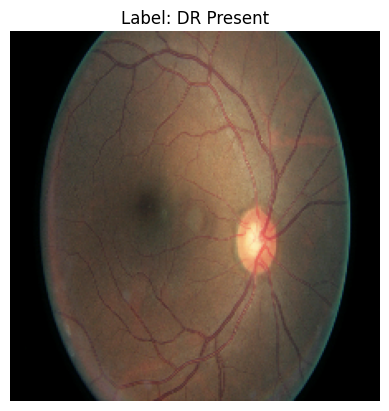

In [21]:
def show_images(images, labels, class_names={0: 'No DR', 1: 'DR Present'}, n=25):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names.get(labels[i], str(labels[i])))
        plt.axis('off')
    plt.suptitle("Sample Images", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()


index = 0  # Change this to view another image
image = X_train[index]
label = y_train[index]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),n=5)
plt.title(f"Label: {'DR Present' if label == 1 else 'No DR'}")
plt.axis('off')
plt.show()

In [22]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

I0000 00:00:1753772591.111992      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753772591.112228      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Xception

In [23]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

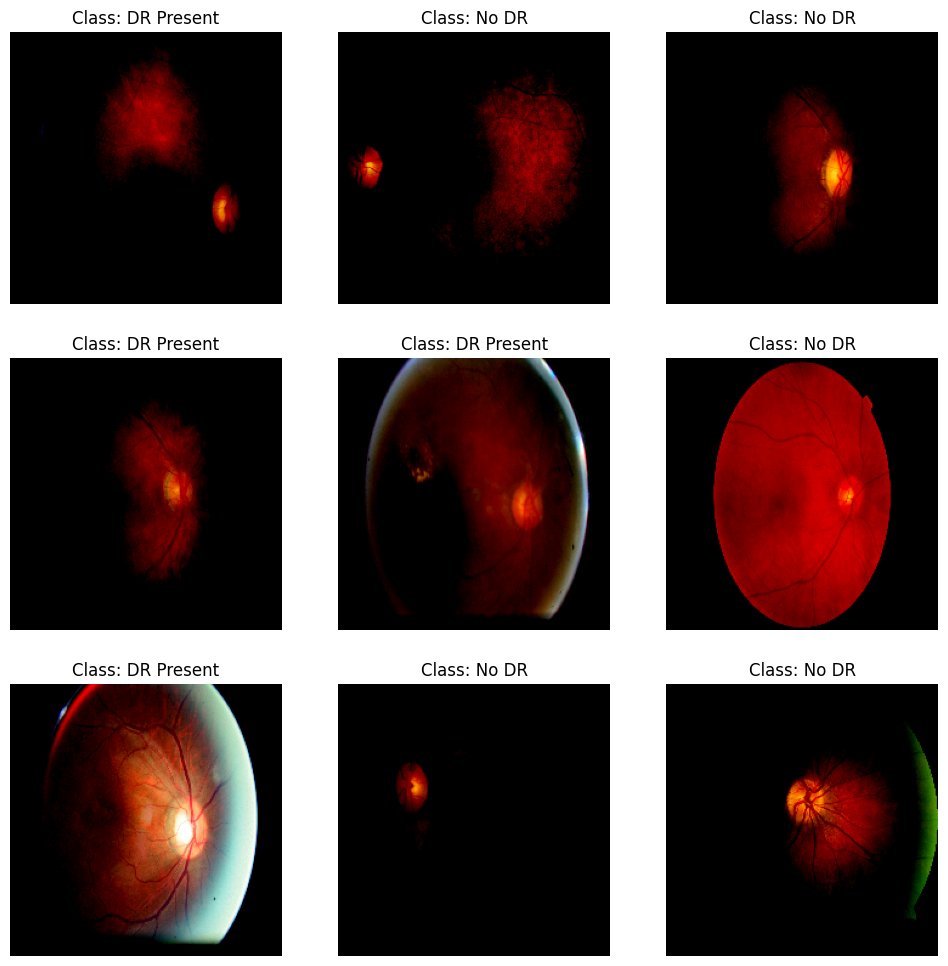

In [24]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        img = (X_batch[index].numpy())
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img /np.max(img)) # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt= 'DR Present'
        else:
            classt= "No DR"
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [25]:
tf.random.set_seed(42)  # Ensures reproducibility

tf.keras.backend.clear_session()
# Ensures reproducibility


base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [31]:
import wandb
!wandb login 67ac152bb5247a09732d5efba29cafc07e798763


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [35]:
wandb.init(
    project="Diabetic Retinopathy Detection",   # change this
    name="Xception",        # optional
    config={                       # optional: log hyperparameters
        "epochs": 10,
        "batch_size": 32,
        "learning_rate": 0.001
    }
)

wandb: Currently logged in as: shreyansh5 (shreyansh5-bennett-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [29]:
# Define input shape
input_shape = (1, 224, 224,3 )
# Calculate FLOPs
flops = get_flops(model, input_shape)
macs = flops // 2  # MACs is half the FLOPs for Conv2D

print(f"MACs: {macs}")
print(f"FLOPs: {flops}")

I0000 00:00:1753773516.505986      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1753773516.506208      36 single_machine.cc:361] Starting new session
I0000 00:00:1753773516.508352      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753773516.508584      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753773520.363909      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753773520.364317      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 M


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
# from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

model_name = "DR_Xception"

# checkpoint_callback = ModelCheckpoint(
#     filepath='best_model.keras',  # Path to save the model
#     monitor='val_accuracy',        # yMetric to monitor
#     save_best_only=True,       # Save only the best model
#     save_weights_only=False,   # Save the entire model, not just weights
#     mode='max',                # Mode to minimize the monitored metric
#     verbose=1                  # Verbosity mode
# )
csv_logger = CSVLogger(model_name+'.csv',append = True)

# callbacks = [checkpoint_callback,csv_logger]
callbacks = [csv_logger,wandb.keras.WandbMetricsLogger(log_freq=5)]

In [37]:
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks= callbacks)

Epoch 1/10


I0000 00:00:1753774023.333131     103 service.cc:148] XLA service 0x780e14002790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753774023.336287     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753774023.336313     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753774024.250127     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-29 07:27:12.635396: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,2048,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1536,7,7]{3,2,1,0}, f32[2048,1536,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","w

  1/188 ━━━━━━━━━━━━━━━━━━━━ 56:53 18s/step - accuracy: 0.6875 - loss: 0.6372

I0000 00:00:1753774033.632624     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 301ms/step - accuracy: 0.7099 - loss: 0.6024 - val_accuracy: 0.7259 - val_loss: 0.5812
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 225ms/step - accuracy: 0.7142 - loss: 0.5913 - val_accuracy: 0.7259 - val_loss: 0.5740
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.7177 - loss: 0.5791 - val_accuracy: 0.7284 - val_loss: 0.5684
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.7163 - loss: 0.5754 - val_accuracy: 0.7349 - val_loss: 0.5647
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.7204 - loss: 0.5705 - val_accuracy: 0.7359 - val_loss: 0.5611
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.7246 - loss: 0.5628 - val_accuracy: 0.7379 - val_loss: 0.5603
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.7302 - loss: 0.5562 - val_accuracy: 0.7399 - val_loss: 0.5572
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.7218 - loss: 0.5630 - val

In [38]:
model.save_weights(model_name+'.weights.h5')

# model.load_weights('/kaggle/working/DR_Xception.weights.h5')

In [42]:
Results(model,test_set,save_csv=True,wandb_log=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.7452 - loss: 0.5512
Evaluation results:  [0.5637139678001404, 0.7305389046669006]
Loading....
Accuracy: 0.7305389221556886
Precision: 0.6
Recall: 0.05454545454545454
F1 Score: 0.09999999999999999
ROC AUC: 0.6315380767787921
PRC AUC: 0.4170755945247736
Confusion Matrix: 
[[1434   20]
 [ 520   30]]
Kappa Coefficient: 0.05685898553250812
NPV: 0.7338792221084954
Saved metrics to: Model_metrics.csv


In [47]:
wandb.save("/kaggle/working/DR_Xception_metrics.csv", policy="now")
wandb.save("/kaggle/working/DR_Xception.weights.h5", policy="now")


['/kaggle/working/wandb/run-20250729_072536-49flzl2r/files/working/DR_Xception.weights.h5']

In [52]:
wandb.finish()

Accuracy,▁
F1 Score,▁
Kappa,▁
NPV,▁
PRC AUC,▁
Precision,▁
ROC AUC,▁
Recall,▁
batch/accuracy,▂▃▃▁▂▃▃▂▃▃▃▃▂▃▃▃▃▃▃▃▃█▂▂▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [43]:
inference_Report(model,test_set)

🔍 Capturing memory stats and inference time for 100 images...

📊 Inference Resource Usage Summary (100 images):
CPU RAM Before: 7155.79 MB
CPU RAM After : 7162.92 MB
CPU RAM Used  : 7.12 MB

GPU Mem Before: 1547.20 MB
GPU Mem After : 1577.41 MB
GPU Mem Used  : 30.21 MB

🕒 Inference Time per image: 0.1197 seconds


In [44]:
model_parametersInfo(model)

Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480


# Xception fine tuned

In [48]:
n =len(base_model.layers)
L = int(0.3*n)  # 30% of n
f"{L} trainable of {n} layers"

'39 trainable of 132 layers'

In [49]:
for layer in base_model.layers[-L:]:
    layer.trainable = True

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [53]:
wandb.init(
    project="Diabetic Retinopathy Detection", 
    name="Xception_ft",   # Change this to "VGG_Model_Run", etc. for next model
    resume="allow"
)


In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

csv_logger = CSVLogger(model_name+'_ft.csv',append = True)

callbacks = [csv_logger,wandb.keras.WandbMetricsLogger(log_freq=5)]

In [56]:
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks= callbacks)


Epoch 1/10


E0000 00:00:1753777230.858151     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753777230.998784     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7291 - loss: 0.5713

E0000 00:00:1753777284.749694     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753777284.889489     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


188/188 ━━━━━━━━━━━━━━━━━━━━ 92s 367ms/step - accuracy: 0.7292 - loss: 0.5711 - val_accuracy: 0.7673 - val_loss: 0.5459
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 316ms/step - accuracy: 0.7868 - loss: 0.4592 - val_accuracy: 0.7634 - val_loss: 0.5858
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 317ms/step - accuracy: 0.8725 - loss: 0.2935 - val_accuracy: 0.7683 - val_loss: 0.7535
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 316ms/step - accuracy: 0.9589 - loss: 0.1244 - val_accuracy: 0.7494 - val_loss: 0.8920
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 318ms/step - accuracy: 0.9764 - loss: 0.0719 - val_accuracy: 0.7504 - val_loss: 1.0556
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 318ms/step - accuracy: 0.9853 - loss: 0.0403 - val_accuracy: 0.7439 - val_loss: 1.1395
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 317ms/step - accuracy: 0.9904 - loss: 0.0323 - val_accuracy: 0.7009 - val_loss: 1.1578
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 318ms/step - accuracy: 0.9931 - loss: 0.0222 - val

In [57]:
model_name = model_name+'_ft'
model_name

'DR_Xception_ft'

In [58]:
model.save_weights(model_name+'.weights.h5')

# model.load_weights('/kaggle/working/DR_Xception.weights.h5')

In [71]:

Results(model,test_set,model_name=model_name,save_csv=True,wandb_log=False)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.7662 - loss: 1.2548
Evaluation results:  [1.3818010091781616, 0.7450099587440491]
Loading....
Accuracy: 0.7450099800399201
Precision: 0.5719557195571956
Recall: 0.2818181818181818
F1 Score: 0.37758830694275275
ROC AUC: 0.6908703263723897
PRC AUC: 0.5116248505194625
Confusion Matrix: 
[[1338  116]
 [ 395  155]]
Kappa Coefficient: 0.23986330003919287
NPV: 0.7720715522215811
Saved metrics to: DR_Xception_ft.csv


In [75]:
wandb.save(f"/kaggle/working/{model_name}.csv", policy="now")
wandb.save(f"/kaggle/working/{model_name}.weights.h5", policy="now")
print(f"saved to wandb {model_name}")

saved to wandb DR_Xception_ft


In [72]:
inference_Report(model,test_set)

🔍 Capturing memory stats and inference time for 100 images...

📊 Inference Resource Usage Summary (100 images):
CPU RAM Before: 7903.39 MB
CPU RAM After : 7903.39 MB
CPU RAM Used  : 0.00 MB

GPU Mem Before: 1628.69 MB
GPU Mem After : 1658.90 MB
GPU Mem Used  : 30.21 MB

🕒 Inference Time per image: 0.1139 seconds


In [73]:
model_parametersInfo(model)

Total params: 20,863,529
Trainable params: 10,556,377
Non-trainable params: 10,307,152


In [74]:
# Define input shape
input_shape = (1, 224, 224,3 )
# Calculate FLOPs
flops = get_flops(model, input_shape)
macs = flops // 2  # MACs is half the FLOPs for Conv2D

print(f"MACs: {macs}")
print(f"FLOPs: {flops}")

I0000 00:00:1753778855.420729      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1753778855.420903      36 single_machine.cc:361] Starting new session
I0000 00:00:1753778855.422969      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753778855.423168      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753778859.398432      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753778859.398718      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 M


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [76]:
wandb.finish()

Accuracy,▁
F1 Score,▁
Kappa,▁
NPV,▁
PRC AUC,▁
Precision,▁
ROC AUC,▁
Recall,▁
batch/accuracy,▁▁▁▁▁▃▃▃▃▃▄▅▅▅▅▇▆▇▇▇████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
